# KNN с использованием LSH

## Импорт библиотек, установка константных значений

In [ ]:
import numpy as np

RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)

## Генерация данных

Для демонстрации сгенерируем датасет из нормального распределения, где $m$ - число объектов, $n$ - число признаков.

In [ ]:
m = 100000
n = 10000   

$q$ - вектор запроса (query), для которого мы ищем ближайших соседей.

In [ ]:
X = rng.normal(size=(m, n))  # датасет
q = rng.normal(size=n)       # вектор запроса

## Поиск с помощью стандартного KNN

In [ ]:
def knn_search(query, data, k=5):

    dists = np.sqrt(np.sum((data - query) ** 2, axis=1))  # вычисляем расстояния от объекта query до всех точек датасета
    inds = np.argsort(dists)  # сортируем по возрастанию расстояний
    inds_k = inds[:k]         # берем top-k точек с наименьшими расстояниями
    
    return data[inds_k], dists[inds_k]

Найдем 5 ближайших соседей методом KNN.

Также замерим время работы поиска.

In [ ]:
%%time

neighbors, dists = knn_search(q, X)  
for i, (neighbor, dist) in enumerate(zip(neighbors, dists)):
    print(f"top {i + 1}: dist = {dist}")

## KNN с использованием LSH

Идея метода состоит в том, что:
* Сначала при помощи LSH отбираем объекты, похожие на объект query
* Затем при помощи KNN ищем ближайшие объекты к query только среди похожих, найденных на предыдущем шаге

Используем метод LSH с кодированием при помощи случайных проекций. Он состоит в следующем:
* проводим несколько случайных гиперплоскостей
* для каждой плоскости: для каждого объекта ставим 1, если объект лежит выше плоскости, и 0 иначе
* тогда каждый объект кодируется вектором из 0 и 1, где длина вектора равна числу сгенерированных гиперплоскостей

Объекты похожи, если их кодировки совпадают.

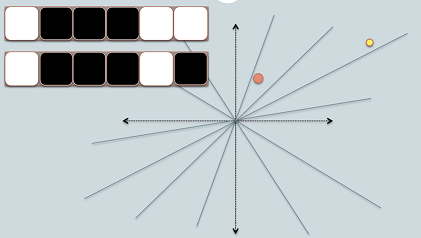

Следующая функция вычисляет количество случайных гиперплоскостей и генерирует их, основываясь на том, сколько в среднем мы хотим получать объектов в одной корзине после хеширования (`bucket_size`).

In [ ]:
def generate_hyperplanes(data, bucket_size=16):
    m = data.shape[0]            # число объектов
    n = data.shape[1]            # число признаков
    b = m // bucket_size         # количество корзин
    h = int(np.log2(b))          # количество гиперплоскостей
    H = rng.normal(size=(h, n))  # гиперплоскости, заданные своими нормалями
    return H

Следующая функция хеширует данные, основываясь на полученных гиперплоскостях, то есть кодирует объект вектором из 0 и 1.

Затем для удобства функция переводит вектор в число путем перевода из двоичной системы в десятичную.

Например: $[0, 1, 1, 0] \to 0 \cdot 1 + 1 \cdot 2 + 1 \cdot 4 + 0 \cdot 8 = 6$

Между двоичной и десятичной записью взаимно однозначное соответствие, но десятичная запись удобнее.  
По сути полученное число - это номер корзины, в которую попадает объект.

In [ ]:
def hamming_hash(data, hyperplanes):
    b = len(hyperplanes)
    hash_key = (data @ hyperplanes.T) >= 0
    
    dec_vals = np.array([2 ** i for i in range(b)], dtype=int)
    hash_key = hash_key @ dec_vals
    
    return hash_key

Теперь мы умеем по каждому объекту определять номер корзины, в которую он попадает.

Функция ниже создает словарь, где для каждой корзины содержатся элементы выборки, попадающие в эту корзину  
(эта структура называется *хеш-таблицей*).

In [ ]:
def locality_sensitive_hash(data, hyperplanes):
    hash_vals = hamming_hash(data, hyperplanes)
    hash_table = {}
    for i, v in enumerate(hash_vals):
        if v not in hash_table:
            hash_table[v] = set()
        hash_table[v].add(i)
        
    return hash_table

Посмотрим, как работают описанные функции.

In [ ]:
hyperplanes = generate_hyperplanes(X)

print('num planes:',len(hyperplanes))
print('normal vector to 1st plane:',hyperplanes[0])

num planes: 12
normal vector to 1st plane: [-0.35327895 -0.1115533   0.10029345 ...  0.70895511 -1.50096947
  1.0183576 ]


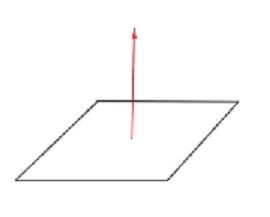

In [ ]:
hamming_hash(q, hyperplanes)

2811

In [ ]:
hash_table = locality_sensitive_hash(X, hyperplanes)
hash_table

{1814: {0,
  6316,
  8614,
  13781,
  15513,
  18065,
  18477,
  21673,
  26492,
  27847,
  32426,
  40377,
  43701,
  47802,
  53311,
  54760,
  56756,
  67352,
  72303,
  85445,
  90859,
  91812,
  94523,
  98023,
  98972},
 2898: {1,
  1201,
  3764,
  5429,
  9251,
  21208,
  23783,
  25664,
  26058,
  31603,
  33098,
  40246,
  49396,
  52465,
  55140,
  59239,
  64572,
  66139,
  71691,
  79882,
  82135,
  82492,
  85346,
  86355,
  89902,
  95869,
  95898,
  96355},
 2770: {2,
  4700,
  15812,
  23899,
  29472,
  30674,
  44212,
  45752,
  50182,
  50803,
  52394,
  52481,
  52825,
  55364,
  57321,
  57683,
  58574,
  66460,
  68325,
  69503,
  69805,
  70961,
  73568,
  78025,
  78575,
  86275,
  87021,
  93784,
  96904,
  97399},
 1646: {3,
  778,
  2366,
  2525,
  5691,
  11323,
  11771,
  14952,
  17321,
  22923,
  24006,
  25117,
  31242,
  37106,
  39522,
  42416,
  43778,
  48424,
  50051,
  54770,
  71433,
  71446,
  86046,
  99361},
 2607: {4,
  7898,
  17172,
  20901,


Теперь реализуем алгоритм поиска KNN с использованием LSH:
* Сначала при помощи LSH отбираем объекты, похожие на объект query
* Затем при помощи KNN ищем ближайшие объекты к query только среди похожих, найденных на предыдущем шаге

In [ ]:
def approx_knn_search(query, data, k=5, bucket_size=16):
    candidates = set()

    hyperplanes = generate_hyperplanes(data)
    hash_table = locality_sensitive_hash(data, hyperplanes) # формируем хеш-таблицу по датасету

    query_hash = hamming_hash(query, hyperplanes)
    if query_hash in hash_table:
        candidates = candidates.union(hash_table[query_hash])
    candidates = np.stack([data[i] for i in candidates], axis=0) # находим кандидатов = объекты, попадающие с query в одну корзину

    return knn_search(query, candidates, k=k) # с помощью KNN ищем ближайших соседей только из найденных кандидатов

In [ ]:
%%time

neighbors, dists = approx_knn_search(q, X)

for i, (neighbor, dist) in enumerate(zip(neighbors, dists)):
    print(f"top {i + 1}: dist = {dist}")

top 1: dist = 140.54359634231741
top 2: dist = 140.55574606796543
top 3: dist = 140.56013419250291
top 4: dist = 140.6196203278344
top 5: dist = 140.7354636882239
CPU times: user 5.52 s, sys: 189 ms, total: 5.71 s
Wall time: 3.06 s


In [5]:
from sklearn.model_selection import LeaveOneOut
X = [1, 2, 3, 4]
loo = LeaveOneOut()
for train, test in loo.split(X):
  print("%s %s" % (train, test))

[1 2 3] [0]
[0 2 3] [1]
[0 1 3] [2]
[0 1 2] [3]
